In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import astropy.units as u
import astropy.coordinates as apycoords
# Suppress warnings. Comment this out if you wish to see the warning messages
import warnings
warnings.filterwarnings('ignore')
from tqdm import tqdm
import seaborn as sns
from astroquery.vizier import Vizier

In [2]:
def make_confusion_matrix(cf, group_names=None, categories='auto', count=True, percent=True, cbar=True, xyticks=True, xyplotlabels=True,
                          sum_stats=True, figsize=None, cmap='Blues', title=None):
    '''
    This function will make a pretty plot of an sklearn Confusion Matrix cm using a Seaborn heatmap visualization.

    Arguments
    ---------
    cf:            confusion matrix to be passed in

    group_names:   List of strings that represent the labels row by row to be shown in each square.

    categories:    List of strings containing the categories to be displayed on the x,y axis. Default is 'auto'

    count:         If True, show the raw number in the confusion matrix. Default is True.

    normalize:     If True, show the proportions for each category. Default is True.

    cbar:          If True, show the color bar. The cbar values are based off the values in the confusion matrix.
                   Default is True.

    xyticks:       If True, show x and y ticks. Default is True.

    xyplotlabels:  If True, show 'True Label' and 'Predicted Label' on the figure. Default is True.

    sum_stats:     If True, display summary statistics below the figure. Default is True.

    figsize:       Tuple representing the figure size. Default will be the matplotlib rcParams value.

    cmap:          Colormap of the values displayed from matplotlib.pyplot.cm. Default is 'Blues'
                   See http://matplotlib.org/examples/color/colormaps_reference.html
                   
    title:         Title for the heatmap. Default is None.

    '''


    # CODE TO GENERATE TEXT INSIDE EACH SQUARE
    blanks = ['' for i in range(cf.size)]

    if group_names and len(group_names)==cf.size:
        group_labels = ["{}\n".format(value) for value in group_names]
    else:
        group_labels = blanks

    if count:
        group_counts = ["{0:0.0f}\n".format(value) for value in cf.flatten()]
    else:
        group_counts = blanks

    if percent:
        group_percentages = ["{0:.2%}".format(value) for value in cf.flatten()/np.sum(cf)]
    else:
        group_percentages = blanks

    box_labels = [f"{v1}{v2}{v3}".strip() for v1, v2, v3 in zip(group_labels,group_counts,group_percentages)]
    box_labels = np.asarray(box_labels).reshape(cf.shape[0],cf.shape[1])


    # CODE TO GENERATE SUMMARY STATISTICS & TEXT FOR SUMMARY STATS
    if sum_stats:
        #Accuracy is sum of diagonal divided by total observations
        accuracy  = np.trace(cf) / float(np.sum(cf))

        #if it is a binary confusion matrix, show some more stats
        if len(cf)==2:
            #Metrics for Binary Confusion Matrices
            precision = cf[1,1] / sum(cf[:,1])
            recall    = cf[1,1] / sum(cf[1,:])
            f1_score  = 2*precision*recall / (precision + recall)
            stats_text = "\n\nAccuracy={:0.3f}\nPrecision={:0.3f}\nRecall={:0.3f}\nF1 Score={:0.3f}".format(
                accuracy,precision,recall,f1_score)
        else:
            stats_text = "\n\nAccuracy={:0.3f}".format(accuracy)
    else:
        stats_text = ""


    # SET FIGURE PARAMETERS ACCORDING TO OTHER ARGUMENTS
    if figsize==None:
        #Get default figure size if not set
        figsize = plt.rcParams.get('figure.figsize')

    if xyticks==False:
        #Do not show categories if xyticks is False
        categories=False


    # MAKE THE HEATMAP VISUALIZATION
    plt.figure(figsize=figsize)
    sns.heatmap(cf,annot=box_labels,fmt="",cmap=cmap,cbar=cbar,xticklabels=categories,yticklabels=categories)

    if xyplotlabels:
        plt.ylabel('True label')
        plt.xlabel('Predicted label' + stats_text)
    else:
        plt.xlabel(stats_text)
    
    if title:
        plt.title(title)

In [3]:
####### CLUSTERS HUNT 2023 #################
catalog = 'J/A+A/673/A114/clusters' #Improving the open cluster census. II Hunt & Reffert-2023
query = Vizier(catalog=catalog, row_limit=-1).query_constraints()[0]
hunt_sample = query.to_pandas()#.sort_values('DistPc')
hunt_sample = hunt_sample.fillna(0)
hunt_sample = hunt_sample.rename(columns={'Name':'cluster','RA_ICRS': 'ra','DE_ICRS': 'dec', 'pmRA':'pmra',\
                                          'pmDE':'pmdec','Plx':'parallax','N':'n_stars'})
hunt_sample['d'] = 1000. / hunt_sample.parallax
hunt_sample = hunt_sample[(hunt_sample['d'] > 0.) & (hunt_sample['d'] <= 7000.) & (hunt_sample['n_stars'] > 20) & (hunt_sample['n_stars'] < 1e4)]
clusters_hunt = hunt_sample[['cluster','ra','dec','pmra','pmdec','r50','n_stars','parallax','d','X', 'Y', 'Z']]
clusters_hunt

,cluster,ra,dec,pmra,pmdec,r50,n_stars,parallax,d,X,Y,Z
1,ADS_16795,352.592165,58.553413,18.656604,2.846613,2.653159,41,4.759611,210.101225,-8200.949467,190.523268,11.391597
2,AH03_J0748+26.9,117.155887,-26.972679,-2.465490,3.185035,0.034106,68,0.209358,4776.504489,-9916.032137,-3551.448985,-18.194602
3,ASCC_5,14.469082,55.829174,-2.406631,-1.918818,0.054491,25,0.538197,1858.054934,-9084.803224,1435.133769,-189.847236
4,ASCC_6,26.842159,57.738607,-0.834145,0.149175,0.143602,209,0.629667,1588.140201,-9092.167569,1141.104359,-89.948355
5,ASCC_9,41.623901,57.776847,0.168758,-1.138680,0.138439,136,0.402282,2485.818777,-9824.860285,1543.568130,-44.387681
...,...,...,...,...,...,...,...,...,...,...,...,...
7162,vdBergh_85,101.720134,1.324256,-0.957545,0.395344,0.142862,105,0.539945,1852.041755,-9558.985482,-871.427459,12.454071
7163,vdBergh_92,106.036502,-11.442338,-4.385467,1.582681,0.130998,345,0.875270,1142.504037,-8908.878222,-774.710683,-23.731010
7164,vdBergh_113,272.165492,-21.441478,-0.719227,-1.422795,0.126032,163,0.653975,1529.111352,-6728.592103,223.077004,-1.064511
7165,vdBergh_130,304.517447,39.366647,-3.547601,-5.126503,0.106764,162,0.581061,1720.990477,-7743.588494,1633.393016,79.031266


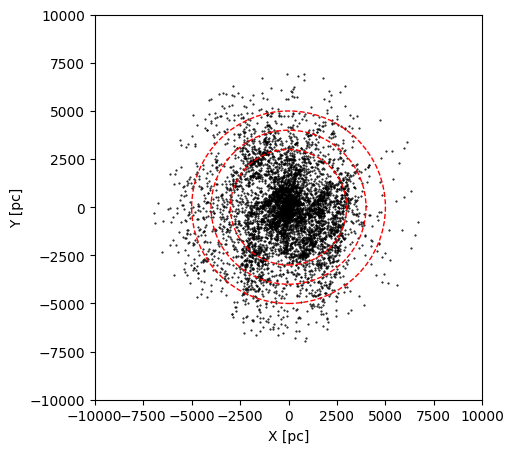

In [5]:
c = apycoords.SkyCoord(ra=clusters_hunt.ra.values *u.deg, dec=clusters_hunt.dec.values *u.deg, distance=clusters_hunt.d.values *u.pc, frame='icrs')
x, y, z = c.galactic.cartesian.x, c.galactic.cartesian.y, c.galactic.cartesian.z
r = 10000.
#radii1 = 6000.
radii2 = 5000.
radii3 = 4000.
radii4 = 3000.

#print(len(clusters_hunt[(clusters_hunt['d'] >= radii1) & (clusters_hunt['d'] <= radii2)]))

fig, ax = plt.subplots(1,1, figsize=(5,5))
#circle1 = plt.Circle((0, 0), radii1, color='r', fill=False, lw=1, ls='--')
circle2 = plt.Circle((0, 0), radii2, color='r', fill=False, lw=1, ls='--')
circle3 = plt.Circle((0, 0), radii3, color='r', fill=False, lw=1, ls='--')
circle4 = plt.Circle((0, 0), radii4, color='r', fill=False, lw=1, ls='--')
ax.scatter(x, y, marker='.', s=1, color='k')
#ax.add_patch(circle1)
ax.add_patch(circle2)
ax.add_patch(circle3)
ax.add_patch(circle4)
ax.set_xlim(-r, r)
ax.set_ylim(-r, r)
ax.set_xlabel('X [pc]')
ax.set_ylabel('Y [pc]')
plt.show()

In [6]:
clusters_alfonso = pd.read_csv('/home/steven/Dropbox/clusters_dat.csv')
del clusters_alfonso['Unnamed: 0']
clusters_alfonso

,cluster,new_stars,ra,dec,pmra,pmdec,parallax,new_logAge,new_z,new_av,new_m_M
0,ASCC_10,129,51.784163,34.847093,-1.815788,-1.470294,1.450102,8.565278,0.108537,0.629316,9.100323
1,ASCC_101,154,288.411534,36.347332,0.978043,1.234214,2.482804,8.441943,0.004296,0.189840,8.079734
2,ASCC_105,181,295.589353,27.492885,1.396109,-1.626063,1.755620,7.891654,0.050715,0.409259,8.770193
3,ASCC_107,63,297.170843,21.961661,-0.222547,-5.136115,1.094851,7.196614,0.352933,1.689755,9.700084
4,ASCC_11,280,53.041281,44.849540,0.919247,-3.075352,1.139830,8.795452,-0.055409,0.600277,9.689326
...,...,...,...,...,...,...,...,...,...,...,...
365,UPK_93,80,300.336527,30.051700,-0.853199,-8.171879,1.350312,8.830048,-0.094012,0.319806,9.199899
366,UPK_94,41,304.721932,27.622928,2.139057,1.012134,1.007615,7.838441,0.108727,0.979499,9.890298
367,UPK_99,62,312.567365,25.551745,0.379925,-7.666714,1.174241,8.129055,-0.100068,0.279814,9.409968
368,vdBergh_80,158,97.635417,-9.548216,-3.257796,0.736237,0.975644,6.995075,-0.140820,1.502164,9.803329


In [14]:
# members_alfonso = pd.read_csv('/home/steven/Dropbox/members_dat.csv')
# del members_alfonso['Unnamed: 0']
# members_alfonso

In [5]:
# import os

# remove_images = False
# if remove_images:
#     path_to_fake_images = "./cmd/fake/"
#     for i in os.listdir(path_to_fake_images):
#         os.remove(os.path.join(path_to_fake_images, i))

#     path_to_real_images = "./cmd/real/"
#     for i in os.listdir(path_to_real_images):
#         os.remove(os.path.join(path_to_real_images, i))

In [7]:
list_clusters_cmd = list(clusters_hunt.cluster.values)
len(list_clusters_cmd)
#list_clusters_cmd

5857

In [8]:
not_cluster_found = []

for i in range(len(clusters_alfonso)):
    if not clusters_alfonso.cluster.values[i] in list_clusters_cmd:
        not_cluster_found.append(clusters_alfonso.cluster.values[i])

len(not_cluster_found)

58

In [9]:
clusters = list_clusters_cmd + not_cluster_found
len(clusters)

5915

In [10]:
clusters = np.array(clusters)
clusters

array(['ADS_16795', 'AH03_J0748+26.9', 'ASCC_5', ..., 'UPK_654', 'UPK_84',
       'UPK_99'], dtype='<U20')

In [11]:
#Gaia.logout()
from PIL import Image

n_cluster = 1
images_array = np.ones((2*len(clusters), 120, 120))
labels = np.zeros((2*len(clusters),), dtype=int)

n_real = 0
n_fake = 1

for c in range(len(clusters)):
    #cluster_name = clusters.cluster.values[c]
    cluster_name = clusters[c]

    real_img = np.array(Image.open('./cmd/real/{}.png'.format(cluster_name)))
    real_img = real_img[np.newaxis, ...]
    images_array[n_real,:,:] = real_img

    fake_img = np.array(Image.open('./cmd/fake/fake_{}.png'.format(n_cluster)))
    fake_img = fake_img[np.newaxis, ...]
    images_array[n_fake,:,:] = fake_img
    
    if (n_real%2) == 0:
        labels[n_real] = 1

    # 0 for fake, 1 for real
    # pares: real, impares:fake
    n_real += 2
    n_fake += 2
    n_cluster += 1

images_array.shape, labels.shape

((11830, 120, 120), (11830,))

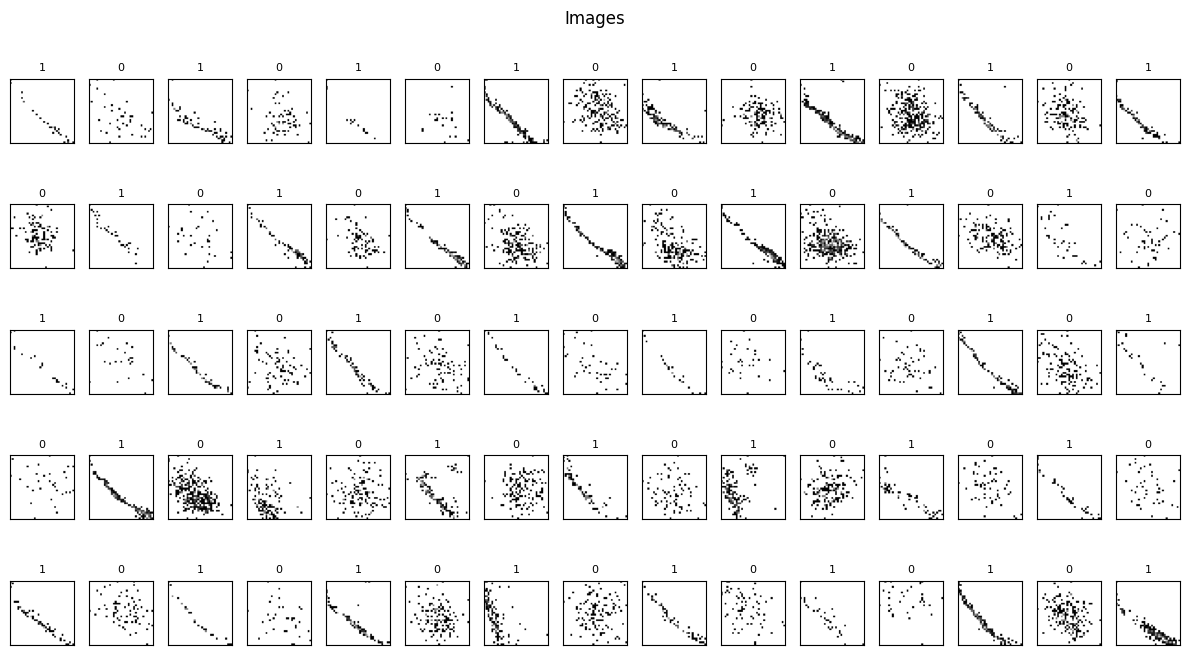

In [12]:
plt.figure(figsize=(12,7))
plt.suptitle('Images')
for i in range(75):
    plt.subplot(5,15,i+1)
    plt.imshow(images_array[i], cmap='gray')
    plt.title(labels[i], fontsize=8)
    plt.tick_params(left=False, right=False, labelleft=False, labelbottom=False, bottom=False)
plt.tight_layout()
plt.show()

In [10]:
# # MLP and LogisticRegression
# from sklearn.model_selection import train_test_split
# from sklearn.preprocessing import StandardScaler
# import sklearn.neural_network
# from sklearn.metrics import confusion_matrix
# from sklearn.linear_model import LogisticRegression
# from sklearn.ensemble import RandomForestClassifier

# X = images_array.reshape(-1, images_array.shape[1]*images_array.shape[2])
# Y = labels

# scaler = StandardScaler()
# x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.3)
# x_train = scaler.fit_transform(x_train)
# x_test = scaler.fit_transform(x_test)

# mlp = sklearn.neural_network.MLPClassifier(activation='logistic', hidden_layer_sizes=(5)) # 5 neurons
# mlp.fit(x_train, y_train)
# y_pred_mlp = mlp.predict(x_test)

# clf = LogisticRegression(C=5, penalty='l1', solver='saga')
# clf.fit(x_train, y_train)
# y_pred_lr = clf.predict(x_test)

# rfc = RandomForestClassifier(random_state=42)
# rfc.fit(x_train, y_train)
# y_pred_rf = rfc.predict(x_test)

In [11]:
# from sklearn.metrics import RocCurveDisplay

# figure = RocCurveDisplay.from_estimator(mlp, x_test, y_test)
# model_disp = RocCurveDisplay.from_estimator(clf, x_test, y_test, ax=figure.ax_)
# model_disp = RocCurveDisplay.from_estimator(rfc, x_test, y_test, ax=figure.ax_)
# model_disp.figure_.suptitle("ROC curve")
# plt.show()

# cm = confusion_matrix(y_pred_mlp, y_test)
# labels = ['True Neg', 'False Pos', 'False Neg', 'True Pos']
# categories = ['0','1']
# make_confusion_matrix(cm, group_names=labels, categories=categories, cmap='binary')
# plt.show()

# cm = confusion_matrix(y_pred_lr, y_test)
# labels = ['True Neg', 'False Pos', 'False Neg', 'True Pos']
# categories = ['0','1']
# make_confusion_matrix(cm, group_names=labels, categories=categories, cmap='binary')
# plt.show()

# cm = confusion_matrix(y_pred_rf, y_test)
# labels = ['True Neg', 'False Pos', 'False Neg', 'True Pos']
# categories = ['0','1']
# make_confusion_matrix(cm, group_names=labels, categories=categories, cmap='binary')
# plt.show()

## Split data in x_train_full and x_test

Dimensiones de los datos de Training: (9464, 120, 120) (9464,)
Dimensiones de los datos de Testing: (2366, 120, 120) (2366,)
(9464, 120, 120, 1) (2366, 120, 120, 1)
Número total de clases:  2
Clases/labels:  [0 1]


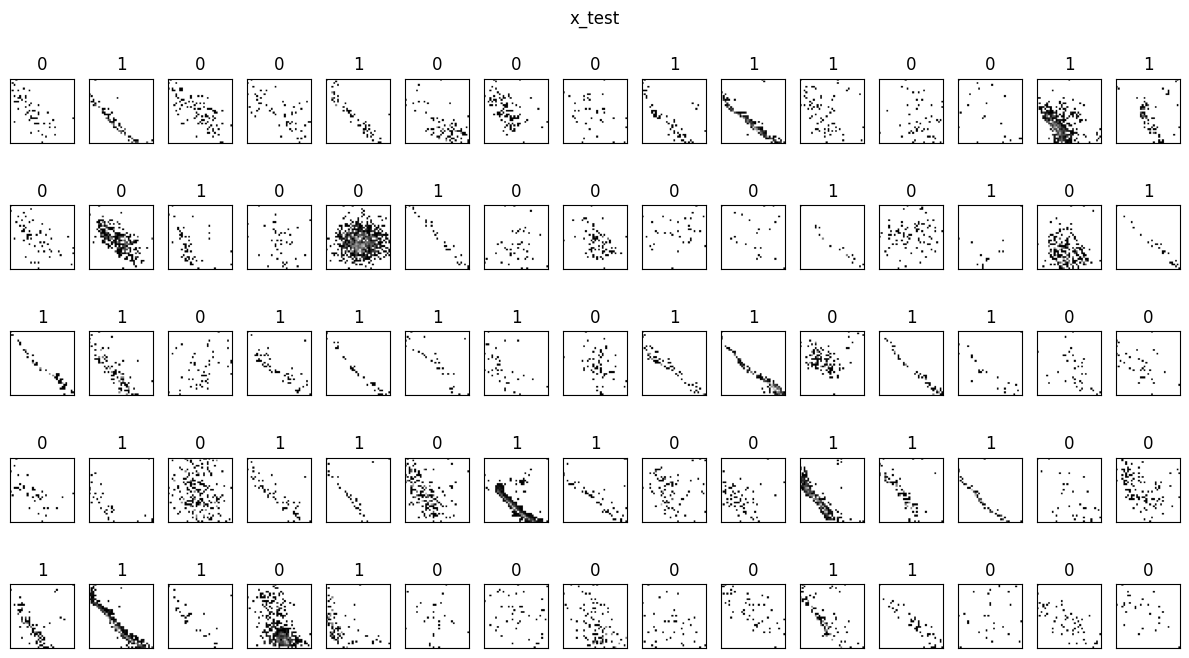

In [13]:
from sklearn.model_selection import train_test_split
x_train_full, x_test, y_train_full, y_test = train_test_split(images_array, labels, test_size=0.2, random_state=42)
print('Dimensiones de los datos de Training:', x_train_full.shape, y_train_full.shape)
print('Dimensiones de los datos de Testing:', x_test.shape, y_test.shape)

# Normalize the images
x_train_full = x_train_full.astype('float32')
x_test = x_test.astype('float32')
x_train_full = x_train_full / 255.
x_test = x_test / 255.

# Reshape the images
x_train_full = np.expand_dims(x_train_full, axis=3)
x_test = np.expand_dims(x_test, axis=3)
print(x_train_full.shape, x_test.shape)

classes = np.unique(y_train_full)
nClasses = len(classes)
print('Número total de clases: ', nClasses)
print('Clases/labels: ', classes)

plt.figure(figsize=(12,7))
plt.suptitle('x_test')
for i in range(75):
    plt.subplot(5,15,i+1)
    plt.imshow(x_test[i], cmap='gray')
    plt.title(y_test[i])
    plt.tick_params(left=False, right=False, labelleft=False, labelbottom=False, bottom=False)
plt.tight_layout()
plt.show()

## Split data in x_train, x_test and x_valid

In [14]:
from sklearn.model_selection import train_test_split
x_train, x_valid, y_train, y_valid = train_test_split(x_train_full, y_train_full, test_size=0.2, random_state=42)
print(x_train.shape, x_test.shape, x_valid.shape)
print(y_train.shape, y_test.shape, y_valid.shape)

(7571, 120, 120, 1) (2366, 120, 120, 1) (1893, 120, 120, 1)
(7571,) (2366,) (1893,)


In [32]:
#tensorflow.keras.backend.clear_session()

## Convolutional Neural Network

In [15]:
import tensorflow

tensorflow.random.set_seed(1234)
#from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.layers import Flatten, Conv2D
from tensorflow.keras.layers import MaxPooling2D#, BatchNormalization

2024-08-15 14:46:23.251228: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-08-15 14:46:27.087157: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-08-15 14:46:27.099602: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-08-15 14:46:31.732647: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [16]:
image_rows = x_train.shape[1] 
image_cols = x_train.shape[2]

# cmd_model = Sequential([
#     Conv2D(32, kernel_size=(3,3), activation='relu', input_shape=(image_rows, image_cols, 1), padding='same',\
#                         kernel_regularizer=tf.keras.regularizers.L2(0.01)),
#     MaxPooling2D(pool_size=(2, 2), padding='same'),
#     Dropout(0.1),
#     Conv2D(64, kernel_size=(3,3), activation='relu', input_shape=(image_rows, image_cols, 1), padding='same',\
#                         kernel_regularizer=tf.keras.regularizers.L2(0.01)),
#     MaxPooling2D(pool_size=(2, 2), padding='same'),
#     Dropout(0.2),
#     Flatten(),
#     Dense(32, activation='relu'),
#     Dropout(0.1),
#     Dense(1, activation='sigmoid')
# ])
# #cmd_model.add(Dense(nClasses, activation='softmax')) # for 2 neurons

# kernel_regularizer=tf.keras.regularizers.L2(0.01)

cmd_model = Sequential([
    Conv2D(32, kernel_size=(3,3), activation='relu', input_shape=(image_rows, image_cols, 1), padding='same'),
    MaxPooling2D(pool_size=(2,2), padding='same'),

    Conv2D(64, kernel_size=(3,3), activation='relu', padding='same'),
    MaxPooling2D(pool_size=(2,2), padding='same'),
    Dropout(0.2),

    Conv2D(64, kernel_size=(3,3), activation='relu', padding='same'),
    MaxPooling2D(pool_size=(2,2), padding='same'),
    Dropout(0.2),

    Conv2D(64, kernel_size=(3,3), activation='relu', padding='same'),
    MaxPooling2D(pool_size=(2,2), padding='same'),
    Dropout(0.2),

    Conv2D(32, kernel_size=(3,3), activation='relu', padding='same'),
    MaxPooling2D(pool_size=(2,2), padding='same'),
    Dropout(0.2),
    
    Flatten(),
    Dense(32, activation='relu'),
    Dense(1, activation='sigmoid')
])
#cmd_model.add(Dense(nClasses, activation='softmax')) # for 2 neurons

# tensorflow.keras.utils.plot_model(cmd_model)
# from tensorflow.keras.utils import plot_model
# plot_model(cmd_model)

#metrics = [tensorflow.keras.metrics.Accuracy(), tensorflow.keras.metrics.Precision(), tensorflow.keras.metrics.Recall()]
metrics = ['accuracy', tensorflow.keras.metrics.Precision(), tensorflow.keras.metrics.Recall()]

#cmd_model.compile(loss='sparse_categorical_crossentropy', optimizer=keras.optimizers.Adam(learning_rate=0.01), metrics =['accuracy'])
cmd_model.compile(loss='binary_crossentropy', optimizer=tensorflow.keras.optimizers.Adam(), metrics=metrics)
#cmd_model.compile(loss='categorical_crossentropy', optimizer=keras.optimizers.Adam(learning_rate=0.01), metrics =['accuracy'])
cmd_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 120, 120, 32)      320       
                                                                 
 max_pooling2d (MaxPooling2  (None, 60, 60, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 60, 60, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 30, 30, 64)        0         
 g2D)                                                            
                                                                 
 dropout (Dropout)           (None, 30, 30, 64)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 30, 30, 64)        3

## Train the model

In [17]:
# batch_size = 32 #3800, 100, 32, 50
# epochs = 100 #200
cmd_train = cmd_model.fit(x_train, y_train, batch_size=250, epochs=100, verbose=1, validation_data=(x_valid, y_valid), steps_per_epoch=10)
#validation_split=0.1, steps_per_epoch=10, validation_steps=10

2024-08-15 14:46:55.535446: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 436089600 exceeds 10% of free system memory.


Epoch 1/100


2024-08-15 14:46:57.714099: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 460800000 exceeds 10% of free system memory.
2024-08-15 14:46:58.183585: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 115200000 exceeds 10% of free system memory.
2024-08-15 14:46:58.245912: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 230400000 exceeds 10% of free system memory.
2024-08-15 14:46:58.386531: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 57600000 exceeds 10% of free system memory.


10/10 [==============================] - 31s 3s/step - loss: 0.6954 - accuracy: 0.5172 - precision: 0.5065 - recall: 0.5119 - val_loss: 0.6882 - val_accuracy: 0.5917 - val_precision: 0.9000 - val_recall: 0.2163
Epoch 2/100
10/10 [==============================] - 29s 3s/step - loss: 0.6503 - accuracy: 0.6228 - precision: 0.8100 - recall: 0.3024 - val_loss: 0.5458 - val_accuracy: 0.7961 - val_precision: 0.8949 - val_recall: 0.6761
Epoch 3/100
10/10 [==============================] - 30s 3s/step - loss: 0.4653 - accuracy: 0.8064 - precision: 0.7947 - recall: 0.8324 - val_loss: 0.3541 - val_accuracy: 0.8574 - val_precision: 0.8643 - val_recall: 0.8516
Epoch 4/100
10/10 [==============================] - 27s 3s/step - loss: 0.3985 - accuracy: 0.8393 - precision: 0.8475 - recall: 0.8118 - val_loss: 0.3174 - val_accuracy: 0.8648 - val_precision: 0.8588 - val_recall: 0.8767
Epoch 5/100
10/10 [==============================] - 29s 3s/step - loss: 0.3296 - accuracy: 0.8556 - precision: 0.8442 -

In [18]:
# # Save history
import json
# Get the dictionary containing each metric and the loss for each epoch
history_model = cmd_train.history

json.dump(history_model, open('../data_new_clusters/history_cmd_model', 'w'))
cmd_model.save_weights('../data_new_clusters/120.weights.h5')

## Plot metrics

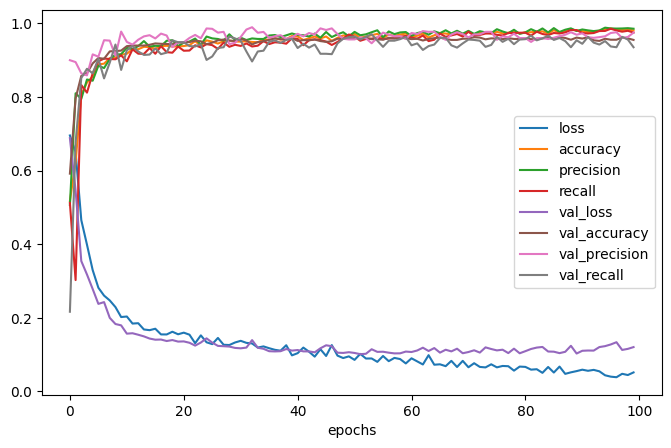

In [22]:
import json
history_model = json.load(open('../data_new_clusters/history_cmd_model', 'r'))
#history_model = cmd_train.history

#cmd_model.save_weights('.weights.h5')
cmd_model.load_weights('../data_new_clusters/120.weights.h5')

pd.DataFrame(history_model).plot(figsize=(8,5))
plt.xlabel('epochs')
#plt.ylabel('accuracy / loss')
plt.show()

In [20]:
#y_test = to_categorical(y_test, num_classes=nClasses)
#y_test = np.argmax(y_test, axis=None, out=None)
test_eval = cmd_model.evaluate(x_test, y_test, verbose=1)
print('Test loss:', test_eval[0])
print('Test accuracy:', test_eval[1])

74/74 [==============================] - 4s 58ms/step - loss: 0.1608 - accuracy: 0.9480 - precision: 0.9705 - recall: 0.9264
Test loss: 0.16083835065364838
Test accuracy: 0.9480135440826416


In [51]:
# predictions = cmd_model.predict(test_images)
# predictions = np.argmax(predictions, axis=1)
# print('Total test images %s' %len(test_images))

# predictions.shape, y_test.shape
# correct = 0
# for i in range(len(predictions)):
#     if predictions[i] == y_test[i]:
#         correct += 1
# print('CNN found %s correct labels.' %correct)
# print('CNN found %s incorrect labels.' %(len (test_images) - correct))

## Predictions on x_test

74/74 [==============================] - 4s 59ms/step


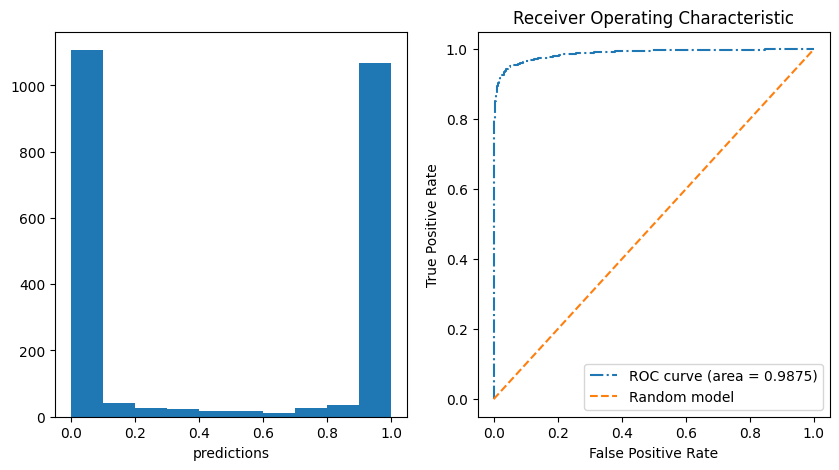

CNN found 2200 correct labels.
CNN found 166 incorrect labels.


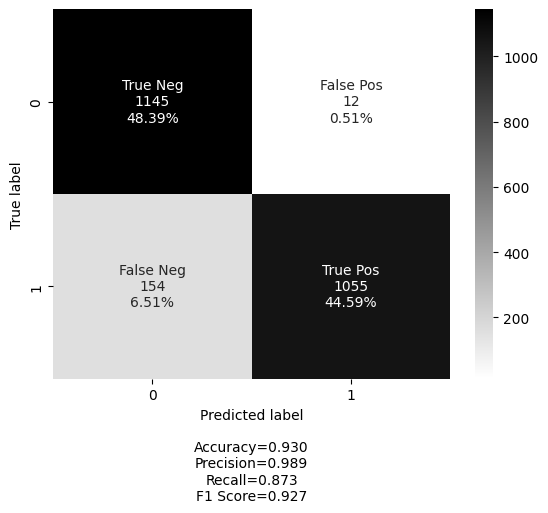

In [23]:
from sklearn.metrics import roc_curve, auc

predictions = cmd_model.predict(x_test)
fpr, tpr, _ = roc_curve(y_test, predictions)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(10,5))

plt.subplot(1,2,1)
plt.hist(predictions)
#plt.ylabel('True Positive Rate')
plt.xlabel('predictions')
#plt.title('Receiver Operating Characteristic')

plt.subplot(1,2,2)
plt.plot(fpr, tpr, ls='-.', label='ROC curve (area = %0.4f)'%roc_auc)
plt.plot([0,1], [0,1], label='Random model', ls='--')
plt.legend()
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.show()


y_pred = np.zeros_like(y_test)
correct_list = []
wrong_list = []
correct = 0

threshold = 0.9
for i in range(len(predictions)):
    if predictions[i] >= threshold:
        y_pred[i] = 1
    else:
        y_pred[i] = 0

    if y_pred[i] == y_test[i]:
        correct += 1
        correct_list.append(i)
    else:
        wrong_list.append(i)

print('CNN found %s correct labels.' %correct)
print('CNN found %s incorrect labels.' %(len (x_test) - correct))

from sklearn.metrics import confusion_matrix

#cm = confusion_matrix(predictions, y_test)
cm = confusion_matrix(y_true=y_test, y_pred=y_pred)
labels = ['True Neg', 'False Pos', 'False Neg', 'True Pos']
categories = ['0','1']
make_confusion_matrix(cm, group_names=labels, categories=categories, cmap='binary')
plt.show()

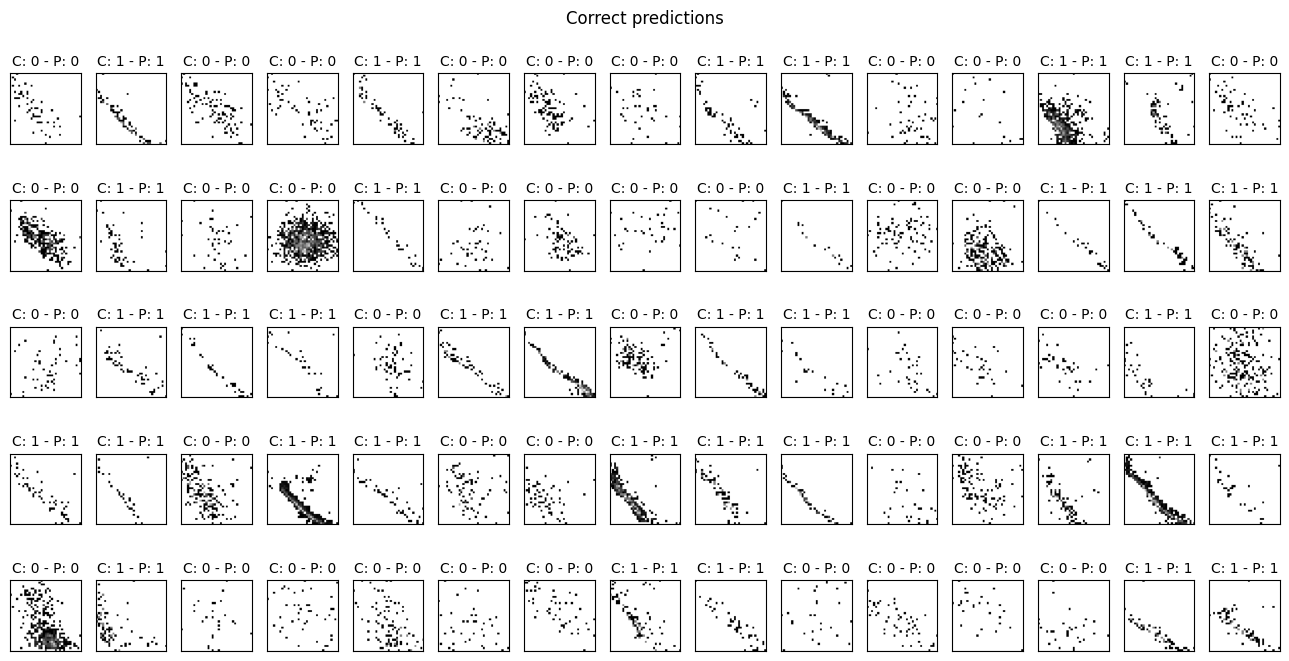

In [24]:
plt.figure(figsize=(13,7))
plt.suptitle('Correct predictions')
for i in range(75):
    plt.subplot(5,15,i+1)
    plt.imshow(x_test[correct_list[i]], cmap='gray')
    plt.title('C: %s - P: %s' %(y_test[correct_list[i]], y_pred[correct_list[i]]), fontsize=10)
    plt.tick_params(left=False, right=False, labelleft=False, labelbottom=False, bottom=False)
plt.tight_layout()
plt.show()

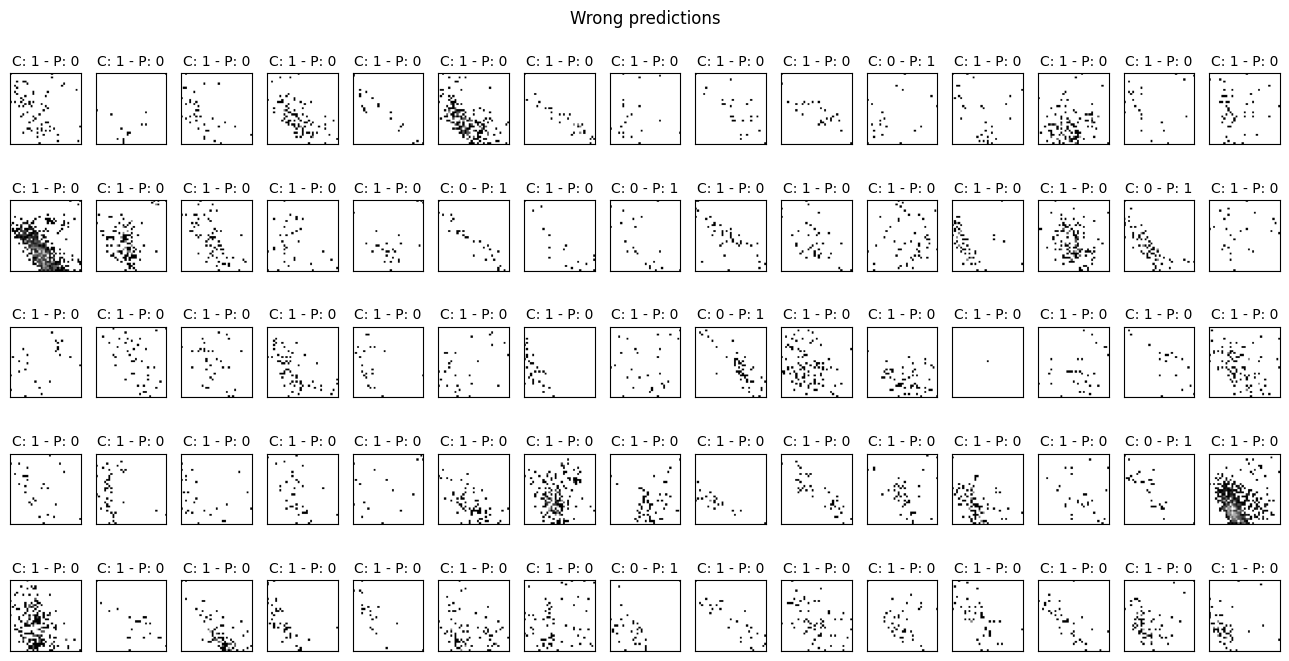

In [25]:
plt.figure(figsize=(13,7))
plt.suptitle('Wrong predictions')
for i in range(75):
    plt.subplot(5,15,i+1)
    plt.imshow(x_test[wrong_list[i]], cmap='gray')
    plt.title('C: %s - P: %s' %(y_test[wrong_list[i]], y_pred[wrong_list[i]]), fontsize=10)
    plt.tick_params(left=False, right=False, labelleft=False, labelbottom=False, bottom=False)
plt.tight_layout()
plt.show()

## Capture images from clusters found by HDBSCAN 

In [18]:
# convert quadrant images to be predicted by the model
import os
#import glob

quadrant = 1
path_to_clusters = '../data_new_clusters/shell1/clusters{}/'.format(quadrant)
clusters_list = os.listdir(path_to_clusters)
image_raw_clusters = np.ones((len(clusters_list), 60, 60))

# delete_images = False
# if delete_images:
#     file_paths = glob.glob(os.path.join('./cmd/Q{}/'.format(quadrant), '*.png'))
#     for file_path in file_paths:
#         os.remove(file_path)

get_cluster_cmds = False
for i in range(len(clusters_list)):
    cluster = pd.read_csv(os.path.join(path_to_clusters, clusters_list[i]))
    color_ = cluster['phot_bp_mean_mag'] - cluster['phot_rp_mean_mag']
    g_mag = cluster['phot_g_mean_mag']
    my_dpi = plt.rcParams['figure.dpi']
    px = 1 / my_dpi

    if get_cluster_cmds:
        fig_cluster = plt.figure(figsize=((n_pixel-1) * px, n_pixel * px), frameon=False)
        plt.scatter(color_, g_mag, marker='s', s=s, c="k")
        plt.tick_params(left=False, right=False, labelleft=False, labelbottom=False, bottom=False)
        plt.gca().invert_yaxis()
        plt.savefig('./cmd/Q{}/{}.png'.format(quadrant, clusters_list[i]), dpi=my_dpi, bbox_inches='tight', pad_inches=0)
        plt.close(fig_cluster)
        Image.open('./cmd/Q{}/{}.png'.format(quadrant, clusters_list[i])).convert('L').save('./cmd/Q{}/{}.png'.format(quadrant, clusters_list[i]))

    cluster_img = np.array(Image.open('./cmd/Q{}/{}.png'.format(quadrant, clusters_list[i])))
    cluster_img = cluster_img[np.newaxis, ...]
    image_raw_clusters[i,:,:] = cluster_img

image_raw_clusters.shape

(1738, 60, 60)

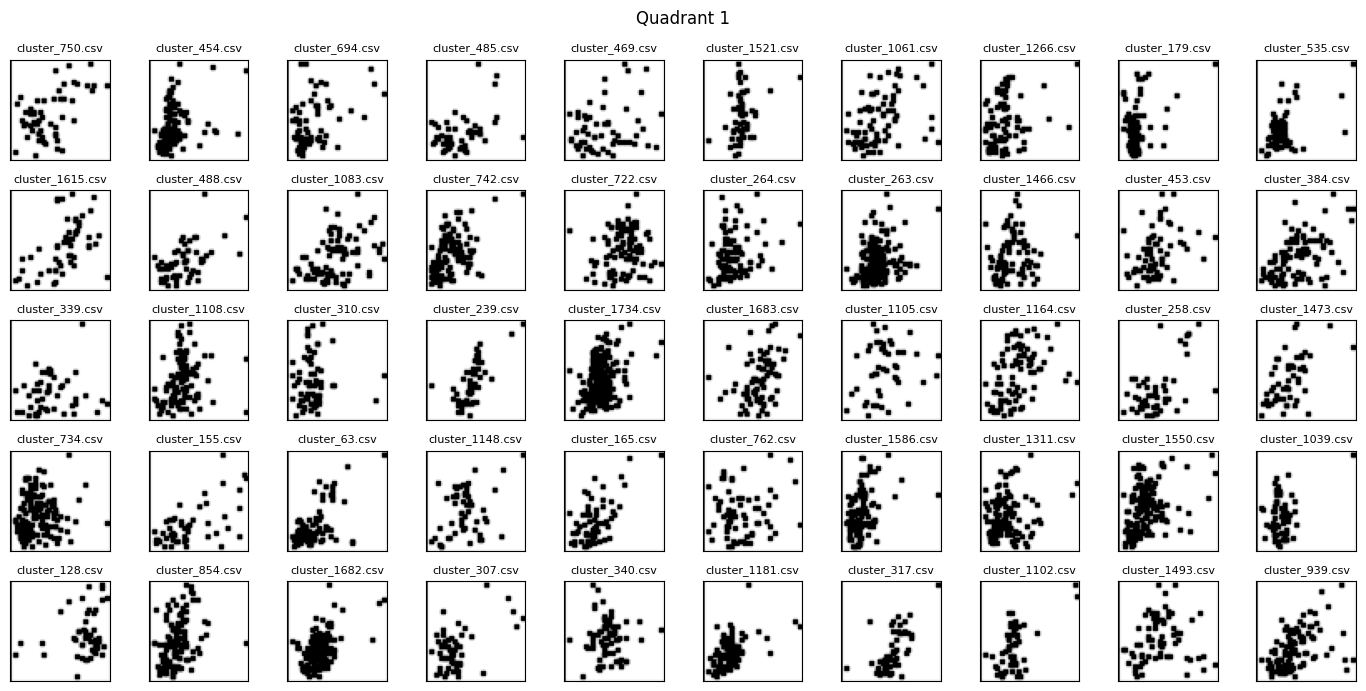

In [19]:
plt.figure(figsize=(14,7))
plt.suptitle('Quadrant %s' %quadrant)
n = 50
for i in range(n):
    plt.subplot(int(n/10),10,i+1)
    plt.imshow(image_raw_clusters[i], cmap='gray')
    plt.title(clusters_list[i], fontsize=8)
    plt.tick_params(left=False, right=False, labelleft=False, labelbottom=False, bottom=False)
plt.tight_layout()
plt.show()

## Convert images that can be read by CNN

(1738, 60, 60, 1)
55/55 [==============================] - 1s 16ms/step
Total cluster images 1738.
CNN found 415 real clusters.
CNN found 1323 fake clusters.


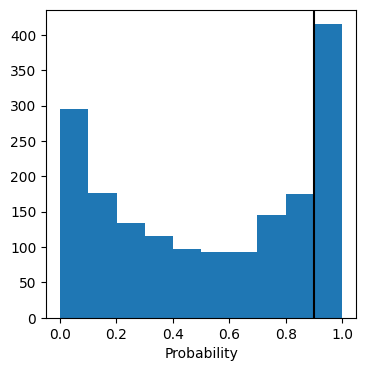

In [23]:
# normalize cluster images
image_clusters = image_raw_clusters.astype('float32')
image_clusters = image_clusters / 255.

image_clusters = np.expand_dims(image_clusters, axis=3)
print(image_clusters.shape)

# get filenames for real clusters
# 0 for fake, 1 for real
cluster_predictions = cmd_model.predict(image_clusters)
#cluster_predictions = np.argmax(cluster_predictions, axis=1)
print('Total cluster images %s.' %len(image_clusters))

list_real_clusters = []
list_fake_clusters = []
threshold = 0.9 # to decide whether or not is a real cluster

for i in range(len(cluster_predictions)):
    if cluster_predictions[i] >= threshold:
        list_real_clusters.append(clusters_list[i])
    else:
        list_fake_clusters.append(clusters_list[i])

print('CNN found %s real clusters.' %len(list_real_clusters))
print('CNN found %s fake clusters.' %len(list_fake_clusters))

#print(list_real_clusters)
#print(list_fake_clusters)

plt.figure(figsize=(4,4))
#plt.title('')
plt.hist(cluster_predictions)
plt.axvline(threshold, c='k')
plt.xlabel('Probability')
plt.show()

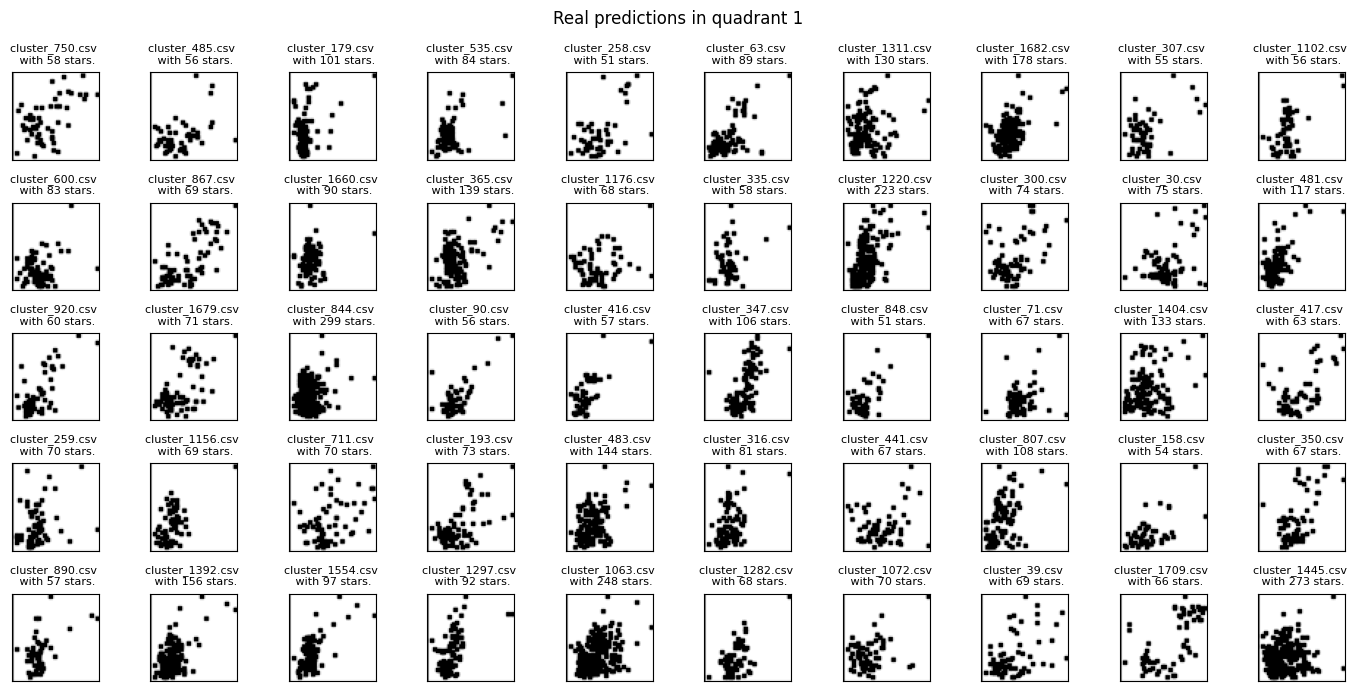

In [24]:
# plot real clusters
path_to_clusters = '../data_new_clusters/shell1/clusters{}/'.format(quadrant)

plt.figure(figsize=(14,7))
plt.suptitle('Real predictions in quadrant %s'%quadrant)
n = 50
for i in range(n):
    plt.subplot(int(n/10),10,i+1)
    cluster = pd.read_csv(os.path.join(path_to_clusters, list_real_clusters[i]))
    read_image = np.array(Image.open('./cmd/Q{}/{}.png'.format(quadrant, list_real_clusters[i])))
    plt.imshow(read_image, cmap='gray')
    plt.title('%s \n with %s stars.'%(list_real_clusters[i], len(cluster)), fontsize=8)
    plt.tick_params(left=False, right=False, labelleft=False, labelbottom=False, bottom=False)
plt.tight_layout()
plt.show()

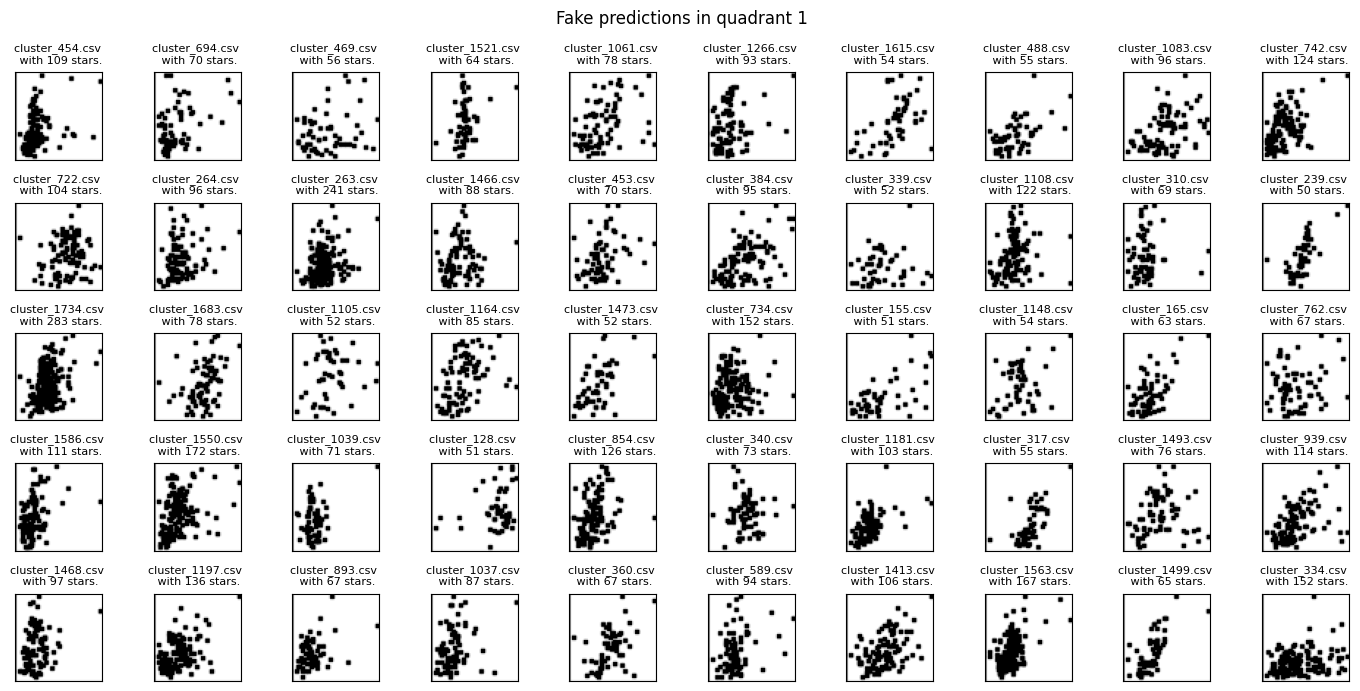

In [25]:
# plot fake clusters
path_to_clusters = '../data_new_clusters/shell1/clusters{}/'.format(quadrant)

plt.figure(figsize=(14,7))
plt.suptitle('Fake predictions in quadrant %s'%quadrant)
n = 50
for i in range(n):
    plt.subplot(int(n/10),10,i+1)
    cluster = pd.read_csv(os.path.join(path_to_clusters, list_fake_clusters[i]))
    read_image = np.array(Image.open('./cmd/Q{}/{}.png'.format(quadrant, list_fake_clusters[i])))
    plt.imshow(read_image, cmap='gray')
    plt.title('%s \n with %s stars.'%(list_fake_clusters[i], len(cluster)), fontsize=8)
    plt.tick_params(left=False, right=False, labelleft=False, labelbottom=False, bottom=False)
plt.tight_layout()
plt.show()

In [35]:
####### CLUSTERS HUNT 2023 #################
from astroquery.vizier import Vizier
catalog = 'J/A+A/673/A114/clusters' #Improving the open cluster census. II Hunt & Reffert-2023
query = Vizier(catalog=catalog, row_limit=-1).query_constraints()[0]
hunt_sample = query.to_pandas()#.sort_values('DistPc')
hunt_sample = hunt_sample.fillna(0)
hunt_sample = hunt_sample.rename(columns={'Name':'cluster','RA_ICRS': 'ra','DE_ICRS': 'dec', 'pmRA':'pmra',\
                                          'pmDE':'pmdec','Plx':'parallax','N':'n_stars'})
hunt_sample['d'] = 1000. / hunt_sample.parallax
#hunt_sample = hunt_sample[(hunt_sample['d'] > 0.) & (hunt_sample['d'] <= 7000.) & (hunt_sample['n_stars'] > 20) & (hunt_sample['n_stars'] < 1e4)]
hunt_sample = hunt_sample[(hunt_sample['d'] > 0.)]
clusters = hunt_sample[['cluster','ra','dec','pmra','pmdec','r50','n_stars','parallax','d','X', 'Y', 'Z']]
clusters

,cluster,ra,dec,pmra,pmdec,r50,n_stars,parallax,d,X,Y,Z
0,1636-283,249.855743,-28.399194,-1.454902,-6.525783,0.016319,38,0.131381,7611.424017,-2248.916442,-834.329905,1276.428553
1,ADS_16795,352.592165,58.553413,18.656604,2.846613,2.653159,41,4.759611,210.101225,-8200.949467,190.523268,11.391597
2,AH03_J0748+26.9,117.155887,-26.972679,-2.465490,3.185035,0.034106,68,0.209358,4776.504489,-9916.032137,-3551.448985,-18.194602
3,ASCC_5,14.469082,55.829174,-2.406631,-1.918818,0.054491,25,0.538197,1858.054934,-9084.803224,1435.133769,-189.847236
4,ASCC_6,26.842159,57.738607,-0.834145,0.149175,0.143602,209,0.629667,1588.140201,-9092.167569,1141.104359,-89.948355
...,...,...,...,...,...,...,...,...,...,...,...,...
7162,vdBergh_85,101.720134,1.324256,-0.957545,0.395344,0.142862,105,0.539945,1852.041755,-9558.985482,-871.427459,12.454071
7163,vdBergh_92,106.036502,-11.442338,-4.385467,1.582681,0.130998,345,0.875270,1142.504037,-8908.878222,-774.710683,-23.731010
7164,vdBergh_113,272.165492,-21.441478,-0.719227,-1.422795,0.126032,163,0.653975,1529.111352,-6728.592103,223.077004,-1.064511
7165,vdBergh_130,304.517447,39.366647,-3.547601,-5.126503,0.106764,162,0.581061,1720.990477,-7743.588494,1633.393016,79.031266


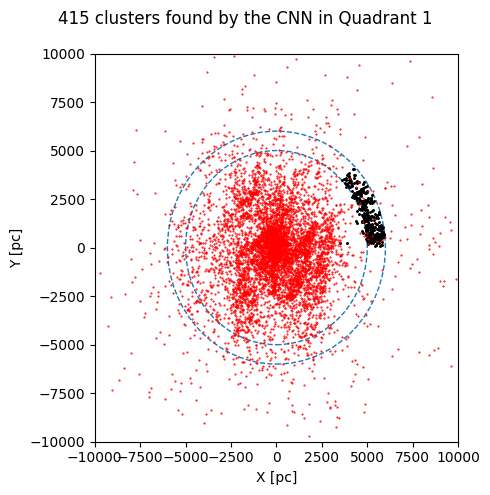

In [36]:
path_to_clusters = '../data_new_clusters/shell1/clusters{}/'.format(quadrant)
r = 10000.

fig, ax = plt.subplots(1,1, figsize=(5,5))
fig.suptitle('%s clusters found by the CNN in Quadrant %s' %(len(list_real_clusters), quadrant))
circle1 = plt.Circle((0, 0), radii1, color='C0', fill=False, lw=1, ls='--')
circle2 = plt.Circle((0, 0), radii2, color='C0', fill=False, lw=1, ls='--')
ax.add_patch(circle1)
ax.add_patch(circle2)

for i in range(len(list_real_clusters)):
    cluster = pd.read_csv(os.path.join(path_to_clusters, list_real_clusters[i]))
    ra = np.median(cluster.ra.values) *u.deg
    dec = np.median(cluster.dec.values) *u.deg
    distance = np.median(1000. / cluster.parallax) *u.pc
    c = apycoords.SkyCoord(ra=ra, dec=dec ,distance=distance, frame='icrs')
    x, y, z = c.galactic.cartesian.x, c.galactic.cartesian.y, c.galactic.cartesian.z
    ax.scatter(x, y, marker='.', s=5, color='k')

c_h = apycoords.SkyCoord(ra=clusters.ra.values *u.deg, dec=clusters.dec.values *u.deg, distance=clusters.d.values *u.pc, frame='icrs')
x_h, y_h, z_h = c_h.galactic.cartesian.x, c_h.galactic.cartesian.y, c_h.galactic.cartesian.z
ax.scatter(x_h, y_h, marker='.', s=1, color='r')
ax.set_xlim(-r, r)
ax.set_ylim(-r, r)
ax.set_xlabel('X [pc]')
ax.set_ylabel('Y [pc]')
fig.tight_layout()
plt.show()

In [33]:
len(list_real_clusters)

415

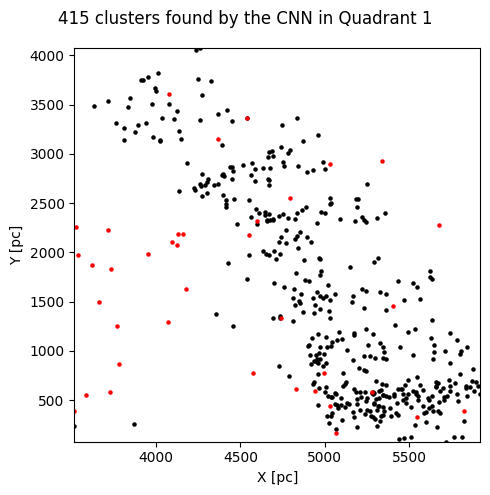

In [41]:
path_to_clusters = '../data_new_clusters/shell1/clusters{}/'.format(quadrant)

fig, ax = plt.subplots(1,1, figsize=(5,5))
fig.suptitle('%s clusters found by the CNN in Quadrant %s' %(len(list_real_clusters), quadrant))
x_ = []
y_ = []

for i in range(len(list_real_clusters)):
    cluster = pd.read_csv(os.path.join(path_to_clusters, list_real_clusters[i]))
    ra = np.median(cluster.ra.values) *u.deg
    dec = np.median(cluster.dec.values) *u.deg
    distance = np.median(1000. / cluster.parallax) *u.pc
    c = apycoords.SkyCoord(ra=ra, dec=dec ,distance=distance, frame='icrs')
    x, y, z = np.array(c.galactic.cartesian.x), np.array(c.galactic.cartesian.y), np.array(c.galactic.cartesian.z)
    ax.scatter(x, y, marker='o', s=5, color='k')
    x_.append(x)
    y_.append(y)

c_h = apycoords.SkyCoord(ra=clusters.ra.values *u.deg, dec=clusters.dec.values *u.deg, distance=clusters.d.values *u.pc, frame='icrs')
x_h, y_h, z_h = c_h.galactic.cartesian.x, c_h.galactic.cartesian.y, c_h.galactic.cartesian.z
ax.scatter(x_h, y_h, marker='o', s=5, color='r')
ax.set_xlim(min(x_), max(x_))
ax.set_ylim(min(y_), max(y_))
ax.set_xlabel('X [pc]')
ax.set_ylabel('Y [pc]')
fig.tight_layout()
plt.show()

### Find nearby clusters from Hunt et al. sample to identify whether or not a clusters is a new candidate

In [50]:
c_h = apycoords.SkyCoord(ra=clusters.ra.values *u.deg, dec=clusters.dec.values *u.deg, distance=clusters.d.values *u.pc, frame='icrs')
x_h, y_h, z_h = np.array(c_h.galactic.cartesian.x), np.array(c_h.galactic.cartesian.y), np.array(c_h.galactic.cartesian.z)

path_to_clusters = '../data_new_clusters/shell1/clusters{}/'.format(quadrant)
r_value = 80. # pc
related_clusters = {}

for i in range(len(list_real_clusters)):
    new_cluster = pd.read_csv(os.path.join(path_to_clusters, list_real_clusters[i]))
    ra_new, dec_new, distance_new = np.median(new_cluster.ra.values) *u.deg, np.median(new_cluster.dec.values) *u.deg, \
                                    1000. / np.median(new_cluster.parallax.values) *u.pc
    c_new = apycoords.SkyCoord(ra=ra_new, dec=dec_new ,distance=distance_new, frame='icrs')
    x_new, y_new, z_new = c_new.galactic.cartesian.x, c_new.galactic.cartesian.y, c_new.galactic.cartesian.z
    
    test_list = []
    for j in range(len(clusters)):

        d = np.sqrt((x_new.value - x_h[j])**2 + (y_new.value - y_h[j])**2 + (z_new.value - z_h[j])**2)
        if d <= r_value:
            print('')
            print('{} may have already been reported: {} is {:.1f} pc away.'.format(list_real_clusters[i], clusters.cluster.values[j], d))
            test_list.append(clusters.cluster.values[j])
    
    if test_list:        
        related_clusters[list_real_clusters[i]] = test_list


cluster_1375.csv may have already been reported: HSC_264 is 35.6 pc away.

cluster_22.csv may have already been reported: NGC_6218 is 6.8 pc away.

cluster_33.csv may have already been reported: NGC_6809 is 37.4 pc away.


In [52]:
related_clusters

{'cluster_1375.csv': ['HSC_264'],
 'cluster_22.csv': ['NGC_6218'],
 'cluster_33.csv': ['NGC_6809']}

cluster_1375.csv does not have common stars with HSC_264
NGC_6218: crossmatch with 104 stars.
New candidate: 116 Hunt: 7248 Crossmatch: 104


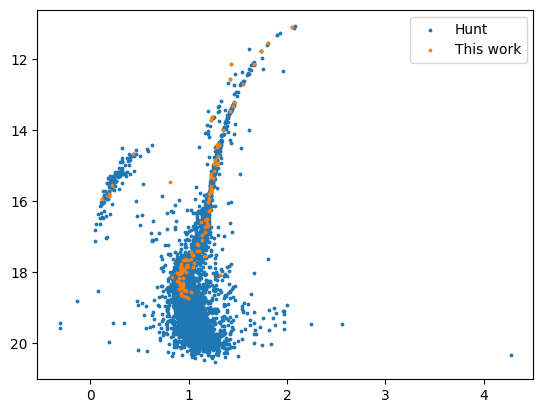

NGC_6809: crossmatch with 52 stars.
New candidate: 53 Hunt: 11103 Crossmatch: 52


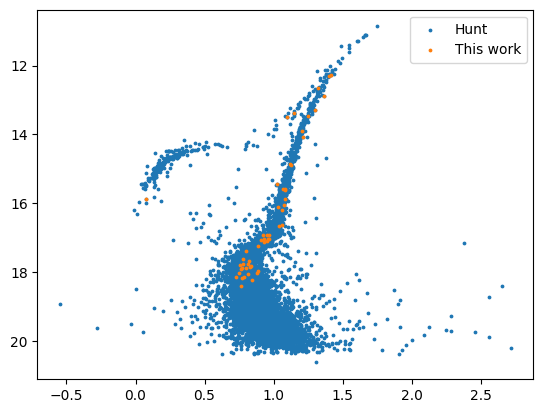

In [61]:
for index, value in enumerate(related_clusters):
    cluster_candidate = pd.read_csv(os.path.join(path_to_clusters, value))

    for i in related_clusters[value]:
        cluster_members = members_h[(members_h.cluster == i)] # Hunt 2023
        cm = pd.merge(cluster_candidate, cluster_members, on=['source_id'], how='inner')
        if len(cm) != 0:
            print('%s: crossmatch with %s stars.'%(i, len(cm)))
            print('New candidate: %s Hunt: %s Crossmatch: %s'%(len(cluster_candidate), len(cluster_members), len(cm)))

            plt.scatter(cluster_members['bp-rp'], cluster_members['phot_g_mean_mag'], label='Hunt', s=3)
            color_band = cluster_candidate['phot_bp_mean_mag'] - cluster_candidate['phot_rp_mean_mag']
            plt.scatter(color_band, cluster_candidate['phot_g_mean_mag'], label='This work', s=3)
            plt.gca().invert_yaxis()
            plt.legend()
            plt.show()
        else:
            print('%s does not have common stars with %s'%(value, i))

In [33]:
# # Look clusters with similar positions to know they have been already reported.
# from astroquery.simbad import Simbad

# path_to_clusters = '../data_new_clusters/shell1/clusters{}/'.format(quadrant)

# #r_value = 80. # pc
# r = 2 * u.arcminute
# #for i in range(len(list_real_clusters)):
# for i in range(1):
#     new_cluster = pd.read_csv(os.path.join(path_to_clusters, list_real_clusters[i]))
#     ra_new, dec_new, distance_new = np.median(new_cluster.ra.values)*u.deg, np.median(new_cluster.dec.values)*u.deg, np.median(1000./new_cluster.parallax)*u.pc
#     c_new = apycoords.SkyCoord(ra=ra_new, dec=dec_new, distance=distance_new, frame='icrs')
#     x_new, y_new, z_new = c_new.galactic.cartesian.x, c_new.galactic.cartesian.y, c_new.galactic.cartesian.z
    
#     c = apycoords.SkyCoord(ra=ra_new, dec=dec_new, frame='icrs')

#     result_table = Simbad.query_region(c, radius=r)
#     print(result_table)

In [34]:
# # Look clusters with similar positions to know they have been already reported.
# from astroquery.simbad import Simbad
# from astroquery.vizier import Vizier
# #import astropy.units as u
# #import astropy.coordinates as coord

# path_to_clusters = '../data_new_clusters/shell1/clusters{}/'.format(quadrant)

# #r_value = 80. # pc
# r = .1 * u.arcminute
# #for i in range(len(list_real_clusters)):
# new_cluster = pd.read_csv(os.path.join(path_to_clusters, list_real_clusters[0]))
# ra_new, dec_new, distance_new = np.median(new_cluster.ra.values)*u.deg, np.median(new_cluster.dec.values)*u.deg, np.median(1000./new_cluster.parallax)*u.pc
# c_new = apycoords.SkyCoord(ra=ra_new, dec=dec_new, distance=distance_new, frame='icrs')
# x_new, y_new, z_new = c_new.galactic.cartesian.x, c_new.galactic.cartesian.y, c_new.galactic.cartesian.z

# c = apycoords.SkyCoord(ra=ra_new, dec=dec_new, frame='icrs')
# result_table = Vizier.query_region(c, radius=r)
# #result_table = Simbad.query_region(c, radius=r).to_pandas()

In [35]:
# result_table#[['MAIN_ID','RA','DEC','COO_BIBCODE']]
# #result_table[['COO_BIBCODE']].values[0]

In [36]:
# apycoords.SkyCoord('{} {}'.format(result_table.as_array()[0][1], result_table.as_array()[0][2]), unit=(u.hourangle, u.deg))